# Visualización de datos

El objetivo de este notebook es mostrar el proceso sobre como se visualizan los rasters empleados asi como el resultado de los procesos de depuración de datos del cálculo de las máscaras de nubes y realizar un análisis exploratorio descriptivo de los datos que se tiene

## Librerias

Instalación de librerias si no se poseen

In [1]:
# Librerias
#!pip install rasterio
#!pip install seaborn
#!pip install scikit-image

Cargar librerias que vamos a usar

In [1]:
from sklearn.preprocessing import MinMaxScaler
from typing import List
from matplotlib import colors
from skimage import exposure

import rasterio as rio
import rasterio.plot as rio_plot
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import json

# Semilla pseudoaleatoria
np.random.seed(24)

# Tamaño de las figuras
plt.rcParams["figure.figsize"] = (20,10)

# Ruta base de la carpeta de datos
DATA_BASE = "/home/ggonzr_cloud/deeplearn/data"

## Exploración

En este apartado vamos a explorar algunas imagenes del conjunto de datos, los archivos que contiene la etiqueta de la imagen y la máscara.

### Carga de imágenes

A continuación asignar en una variable las rutas de acceso a las imagenes.

In [2]:
# Directorios de las etiquetas y la imagenes
LABEL_DIR = f"{DATA_BASE}/ref_landcovernet_v1_labels"
IMAGE_DIR = f"{DATA_BASE}/ref_landcovernet_v1_source"

In [3]:
# Listar los subdirectorios de cada carpeta: Etiquetas
label_dirs = glob.glob(f"{LABEL_DIR}/*")
print(f"Número de etiquetas disponibles: {len(label_dirs)}")

Número de etiquetas disponibles: 1982


In [4]:
# Listar los subdirectorios de cada carpeta: Etiquetas
image_dirs = glob.glob(f"{IMAGE_DIR}/*")
print(f"Número de etiquetas disponibles: {len(image_dirs)}")

Número de etiquetas disponibles: 82430


En las siguientes dos celdas podrá observar un ejemplo de la ruta de acceso tanto de las imagenes satelitales como de sus etiquetas. Cada una de ellas se representa en una carpeta

In [5]:
label_dirs[0]

'/home/ggonzr_cloud/deeplearn/data/ref_landcovernet_v1_labels/ref_landcovernet_v1_labels_36PZC_07'

In [6]:
image_dirs[0]

'/home/ggonzr_cloud/deeplearn/data/ref_landcovernet_v1_source/ref_landcovernet_v1_source_33LYE_11_20180818'

## Carga del preprocesamiento

Con base en el resumen que elaboramos anteriormente sobre las imagenes disponibles y su media de máscara de nubes, vamos a determinar cuántas imagenes tenemos disponibles con un porcentaje de nubes menor o igual a 0.1%

En primer lugar cargamos el archivo **JSON** con el preprocesamiento de la máscara de nubes

In [7]:
mask_clouds_df = pd.read_json(f"{DATA_BASE}/cloud_mask_report.json")

In [8]:
print(f"Imagenes analizadas: {mask_clouds_df.count()[0]}")

Imagenes analizadas: 82398


In [9]:
# Datos
mask_clouds_df.head(2)

,image_id,chip_id,image_folder_path,cloud_mask_mean
0,33LYE_11_20180818,33LYE_11,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0
1,35LNF_07_20180602,35LNF_07,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0


Posteriormente vamos a realizar una consulta sobre el DataFrame para determinar el subconjunto de todas aquellas con una cobertura de nubes menor o igual a 0.1%

In [10]:
# Datos con una media de nubes menor a 0.1%
percentage_1_mask_clouds = mask_clouds_df[mask_clouds_df.cloud_mask_mean <= 0.001]
percentage_1_mask_clouds.count()

image_id             32927
chip_id              32927
image_folder_path    32927
cloud_mask_mean      32927
dtype: int64

Posteriormente, vamos a agrupar las tomas de las imágenes por región de interés

In [11]:
# Agrupar los datos por chip
cols = ["chip_id", "image_id"]
p1_group_count = (
    percentage_1_mask_clouds[cols]
    .groupby("chip_id")
    .count()
)

In [12]:
# Describir la consulta
p1_group_count.describe()

,image_id
count,1837.000000
mean,17.924333
std,12.681203
min,1.000000
25%,8.000000
50%,16.000000
75%,26.000000
max,76.000000


Como podemos observar, tenemos a nuestra disposición 1837 regiones diferentes que poseen imagenes con una probabilidad de cobertura de nubes menor a 1%. De estos grupos, en promedio cada uno posee 17 observaciones (tomas) de esa región. El 25% de este conjunto posee un número de observaciones temporales menor o igual a 8 tomas. Con ello en mente, vamos a seleccionar aquellos grupos que posean un número de imagenes de al menos 10 ejemplos.

In [13]:
GROUP_NUM_EXAMPLES = 10
p1_group_boundary = p1_group_count[p1_group_count.image_id >= GROUP_NUM_EXAMPLES]
print(f"Número de grupos: {p1_group_boundary.count()[0]}")

Número de grupos: 1279


Con ello en mente, el resultado del conteo nos indica que tendríamos 1279 grupos. Para culminar, vamos a reajustar el conjunto de datos para leer las imagenes que posean un porcentaje de nubes inferior a 0.1% y tengan mas de 10 tomas

In [14]:
# Realizar el join
p1_final_groups = (
    percentage_1_mask_clouds
    .join(
        p1_group_boundary,
        on="chip_id",
        how="inner",
        lsuffix="_p1_mask",
        rsuffix="_p1_group"
    )
)

# Limpiar
p1_final_groups = p1_final_groups.drop(columns=["image_id_p1_group"])
p1_final_groups = p1_final_groups.rename(columns={"image_id_p1_mask": "image_id"}, errors="raise")

In [15]:
p1_final_groups

,image_id,chip_id,image_folder_path,cloud_mask_mean
0,33LYE_11_20180818,33LYE_11,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
1798,33LYE_11_20180704,33LYE_11,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
2844,33LYE_11_20181121,33LYE_11,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
15990,33LYE_11_20180311,33LYE_11,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
22345,33LYE_11_20181211,33LYE_11,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
...,...,...,...,...
67613,29PKL_24_20181110,29PKL_24,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
68712,29PKL_24_20181011,29PKL_24,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
69956,29PKL_24_20181215,29PKL_24,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
75430,29PKL_24_20181130,29PKL_24,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000


Para culminar vamos a almacenar este resultado en un archivo **JSON**. Este archivo es el que se va a emplear para el entrenamiento de los modelos

In [16]:
# Almacenar los datos
p1_final_groups.to_json(f"{DATA_BASE}/images_to_use.json")

Cargar nuevamente los datos si hemos reiniciado la sesión

In [7]:
# Cargar datos
p1_final_groups = pd.read_json(f"{DATA_BASE}/images_to_use.json")

In [8]:
# Visualizacion
p1_final_groups

,image_id,chip_id,image_folder_path,cloud_mask_mean
0,33LYE_11_20180818,33LYE_11,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
1798,33LYE_11_20180704,33LYE_11,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
2844,33LYE_11_20181121,33LYE_11,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
15990,33LYE_11_20180311,33LYE_11,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
22345,33LYE_11_20181211,33LYE_11,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
...,...,...,...,...
67613,29PKL_24_20181110,29PKL_24,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
68712,29PKL_24_20181011,29PKL_24,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
69956,29PKL_24_20181215,29PKL_24,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
75430,29PKL_24_20181130,29PKL_24,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000


## Pixeles disponibles

A continuación vamos a crear un histograma que muestre la cantidad de pixeles disponibles por cada categoría. Para ello vamos a emplear el archivo del preprocesamiento que realizamos en el notebook *pixels-count*

In [9]:
# Cargar los datos
pix_df = pd.read_json(f"{DATA_BASE}/pixel_report.json")
pix_df

,1,2,3,4,5,6,7,chip_id,label_folder,0
0,0,0,63403,0,585,0,1548,36PZC_07,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,NaN
1,0,0,0,0,63404,1,2131,31NFH_21,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,NaN
2,0,22763,0,0,71,5878,36824,35JKL_11,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,NaN
3,1319,0,0,285,54404,2841,6687,34MBC_29,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,NaN
4,0,0,17856,13650,2986,0,29282,36NZH_24,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,1762.0
...,...,...,...,...,...,...,...,...,...,...
1975,0,1606,45,0,11445,2201,50239,34JHS_28,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,NaN
1976,0,160,0,0,8146,2262,54891,32PQQ_09,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,77.0
1977,0,0,0,0,29528,3509,32499,35PNL_18,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,NaN
1978,0,204,349,0,341,0,64642,38PKQ_23,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,NaN


A continuación modificamos el DataFrame para añadir el nombre correcto de las columnas

In [11]:
# Significador de las categorias
meaning = [
    "Agua",
    "Suelo desnudo artificial",
    "Suelo desnudo natural",
    "Nieve",
    "Bosque (Woody soil)",
    "Terreno cultivado",
    "Vegetación (semi) natural"
]

meaning_pix = ["Pixeles nulos"] + meaning

In [12]:
# Seleccionar el subconjunto
categ = [str(i) for i in range(0,8)]
pix_categ_df = pix_df[categ]
pix_categ_df.columns = meaning_pix

pix_categ_df

,Pixeles nulos,Agua,Suelo desnudo artificial,Suelo desnudo natural,Nieve,Bosque (Woody soil),Terreno cultivado,Vegetación (semi) natural
0,NaN,0,0,63403,0,585,0,1548
1,NaN,0,0,0,0,63404,1,2131
2,NaN,0,22763,0,0,71,5878,36824
3,NaN,1319,0,0,285,54404,2841,6687
4,1762.0,0,0,17856,13650,2986,0,29282
...,...,...,...,...,...,...,...,...
1975,NaN,0,1606,45,0,11445,2201,50239
1976,77.0,0,160,0,0,8146,2262,54891
1977,NaN,0,0,0,0,29528,3509,32499
1978,NaN,0,204,349,0,341,0,64642


Posteriormente agrupamos los datos por categoria y sumamos para obtener el número de pixeles por cada categoria

In [13]:
# Totalizar
pix_cat_sum = pix_categ_df.sum(axis=0)
pix_cat_sum = pix_cat_sum.to_frame()
pix_cat_sum.columns = ["Pixeles"]

In [14]:
# Describir
pix_cat_sum

,Pixeles
Pixeles nulos,120728.0
Agua,2610737.0
Suelo desnudo artificial,3603115.0
Suelo desnudo natural,21956633.0
Nieve,72998.0
Bosque (Woody soil),35173560.0
Terreno cultivado,19958747.0
Vegetación (semi) natural,46264762.0


A continuación encontrará un gráfico de barras y un gráfico circular indicando la proporción de píxeles existentes por cada categoria

<AxesSubplot:>

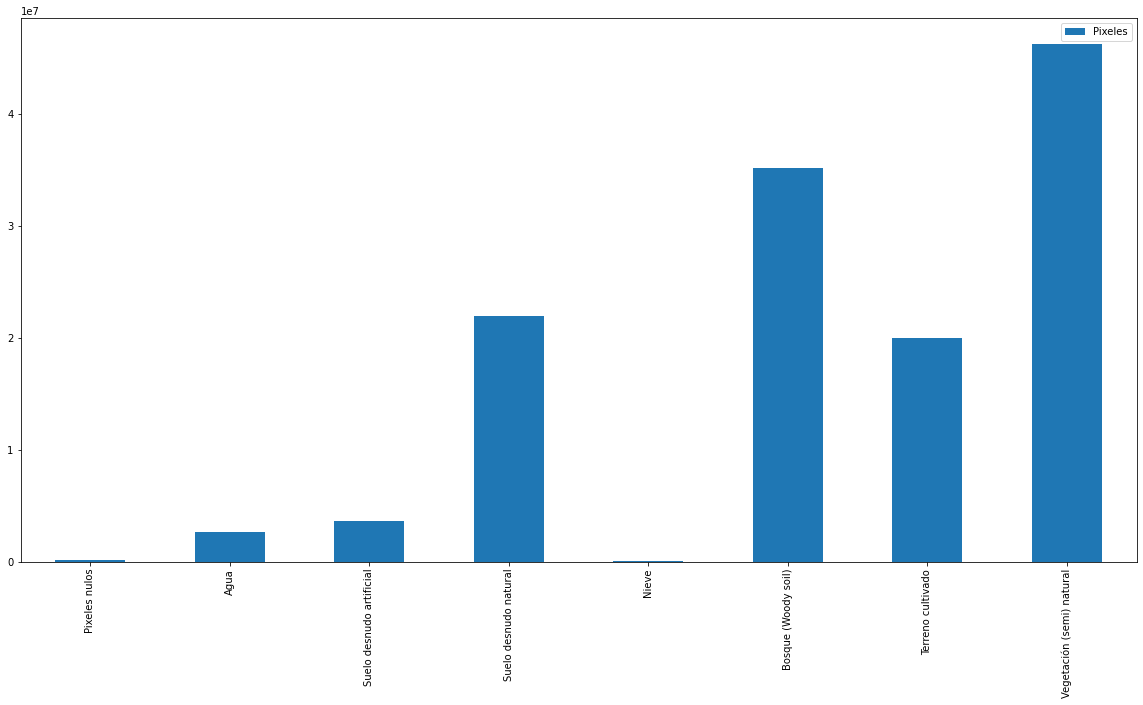

In [15]:
# Visualizar
pix_cat_sum.plot.bar()

<AxesSubplot:title={'center':'Proporcion de pixeles en las máscaras'}, ylabel='Pixeles'>

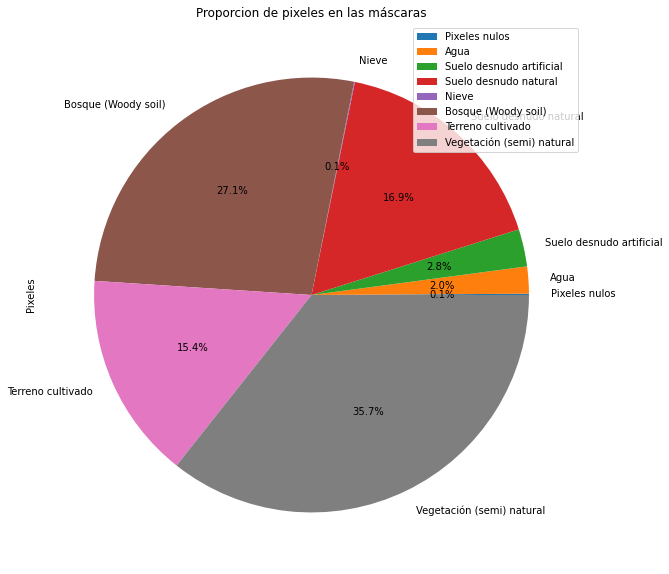

In [16]:
pix_cat_sum.plot.pie(
    y='Pixeles',
    title="Proporcion de pixeles en las máscaras", legend=True,
    autopct='%1.1f%%',
    shadow=False,
)

## Visualización

Después de realizar el análisis exploratorio sobre los píxeles disponibles y a que clases pertenecen, vamos a seleccionar de manera aleatoria una imagen para mostrar su combinació TCI, su máscara y la máscara de nubes

In [17]:
img_sample = (
    p1_final_groups
    .sample(
        n=1,
        random_state=50
    )
)

In [18]:
img_sample

,image_id,chip_id,image_folder_path,cloud_mask_mean
17749,33KVU_14_20180510,33KVU_14,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000244


In [19]:
img_sample_region = img_sample.iloc[0, 1]
print(f"Región seleccionada: {img_sample_region}")

Región seleccionada: 33KVU_14


Seguidamente vamos a seleccionar la máscara y una de las imágenes

In [20]:
mask_info = pd.read_json(f"{DATA_BASE}/image_view.json")

Directorio de la máscara

In [21]:
ex_mask_folder = mask_info.loc["masks", img_sample_region][0]
ex_mask = glob.glob(f"{ex_mask_folder}/labels.*")[0]

Directorio de la imagen

In [22]:
ex_img_folder = img_sample.iloc[0, 2]

A continuación encontrará un ejemplo de la ruta de la imagen

In [23]:
ex_img_folder

'/home/ggonzr_cloud/deeplearn/data/ref_landcovernet_v1_source/ref_landcovernet_v1_source_33KVU_14_20180510'

Para el conjunto de datos de cobertura de terreno en África, cada una de las carpetas de las imagenes de terreno posee un archivo TIFF para cada banda respectiva. En esta ocasión vamos a seleccionar las bandas Rojo, Verde y Azul para realizar una composición en RGB.

In [24]:
# Bandas RGB de la imagen de ejemplo
ex_img_red = glob.glob(f"{ex_img_folder}/B04.*")[0]
ex_img_green = glob.glob(f"{ex_img_folder}/B03.*")[0]
ex_img_blue = glob.glob(f"{ex_img_folder}/B02.*")[0]

Con ello en mente tenemos las siguientes rutas

In [25]:
print(f"Banda roja de la imagen de ejemplo")
print(ex_img_blue)

Banda roja de la imagen de ejemplo
/home/ggonzr_cloud/deeplearn/data/ref_landcovernet_v1_source/ref_landcovernet_v1_source_33KVU_14_20180510/B02.tif


In [26]:
print(f"Máscara semantica")
print(ex_mask)

Máscara semantica
/home/ggonzr_cloud/deeplearn/data/ref_landcovernet_v1_labels/ref_landcovernet_v1_labels_33KVU_14/labels.tif


### Cargar y visualizar

#### Máscara

Utilizando la liberaria **rasterio** vamos a cargar el raster y a visualizar sus metadatos

In [27]:
ex_mask_rio = rio.open(ex_mask)

Entre los metadatos disponibles podemos encontrar las dimensiones de la imagen, el número de canales y su sistema de coordenadas

In [28]:
print(f"Metadatos{ex_mask_rio.meta}")

Metadatos{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 256, 'height': 256, 'count': 2, 'crs': CRS.from_epsg(32733), 'transform': Affine(10.0, 0.0, 401690.0,
       0.0, -10.0, 7814200.0)}


A continuación leemos el primer canal que contiene las etiquetas

In [29]:
# Primera capa con las etiquetas
ex_labels_mask = ex_mask_rio.read(1)

In [30]:
ex_labels_mask

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=uint16)

Posteriormente creamos un mapa de color personalizado para distinguir cada clase de la máscara

In [31]:
# Crear un colormap personalizado para cada una de las etiquetas
# según el documento
cmap = colors.ListedColormap([
    "#0000ff",
    "#888888",
    "#d1a46d",
    "#f5f5ff",
    "#d64c2b",
    "#186818",
    "#00ff00"
])
meaning = [
    "Agua",
    "Suelo desnudo artificial",
    "Suelo desnudo natural",
    "Nieve",
    "Bosque (Woody soil)",
    "Terreno cultivado",
    "Vegetación (semi) natural"
]
boundaries = list(range(1,8))
norm = colors.BoundaryNorm(boundaries, cmap.N)

Con la máscara definida, leemos los datos y aplicamos la máscara de color que definimos anteriormente. Adicionalmente vamos a configurar la leyenda de cada clase

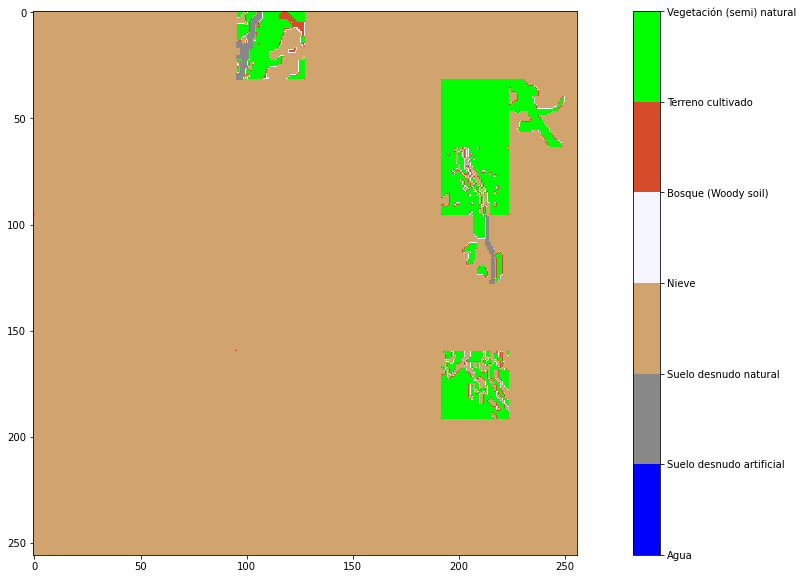

In [32]:
fig, ax = plt.subplots()
img = ax.imshow(ex_mask_rio.read(1), cmap=cmap, norm=norm)
cbar = plt.colorbar(img, ax=ax)
cbar.set_ticks(boundaries)
cbar.set_ticklabels(meaning)
cbar.config_axis
plt.show()

#### Imagen

A continuación vamos a cargar cada uno de los 3 archivos de las bandas de la imagen para poder mostrarla en RGB, igualmente imprimimos sus metadatos

In [33]:
ex_image_red_rio = rio.open(ex_img_red)
ex_image_green_rio = rio.open(ex_img_green)
ex_image_blue_rio = rio.open(ex_img_blue)

In [34]:
print(f"Metadatos{ex_image_red_rio.meta}")

Metadatos{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 256, 'height': 256, 'count': 1, 'crs': CRS.from_epsg(32733), 'transform': Affine(10.0, 0.0, 401690.0,
       0.0, -10.0, 7814200.0)}


A continuación, vamos a cargar las tres bandas de interés en un arreglo de numpy

In [35]:
ex_image_red_rio_data = ex_image_red_rio.read(1)
ex_image_green_rio_data = ex_image_green_rio.read(1)
ex_image_blue_rio_data = ex_image_blue_rio.read(1)

Agrupamos las tres bandas en un mismo arreglo

In [36]:
# Combinación RGB
ex_image_rgb = np.array([
    ex_image_red_rio_data,
    ex_image_green_rio_data,
    ex_image_blue_rio_data
])

Las dimensiones de la imagen en este punto son [canal, alto, ancho]

In [37]:
ex_image_rgb.shape

(3, 256, 256)

A continuación, vamos a emplear una utilidad de **rasterio** para escalar los datos de las bandas espectrales de la imagen Sentinel-2 en un rango de 0.0 a 1.0 y posteriormente la mostramos en pantalla

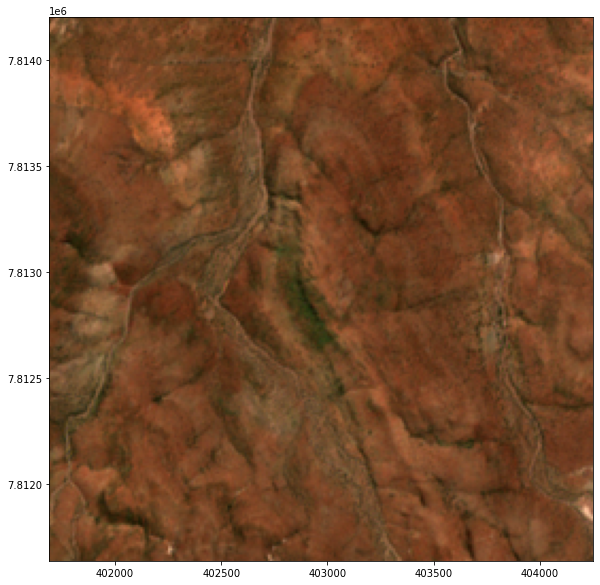

<AxesSubplot:>

In [100]:
rgb = ex_image_rgb
rgb_norm = rio_plot.adjust_band(rgb) # normalize bands to range between 1.0 to 0.0

rio_plot.show(rgb_norm, transform=ex_image_red_rio.transform)

#### Mapa de nubes

Para culminar, vamos a validar que la cobertura de nubes sea minima. Para ello vamos a graficar el mapa de cobertura de nubes y como podrá observar la gran mayoria de los pixeles tiene un porcentaje de probabilidad de nubes de cero.

A continuación cargamos el raster con al cobertura de nubes

In [107]:
ex_img_cloudmask = glob.glob(f"{ex_img_folder}/CLD.*")[0]
ex_cloud_mask = rio.open(ex_img_cloudmask)

In [108]:
print(f"Metadatos de la máscara de nubes: {ex_cloud_mask.meta}")

Metadatos de la máscara de nubes: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 256, 'height': 256, 'count': 1, 'crs': CRS.from_epsg(32733), 'transform': Affine(10.0, 0.0, 401690.0,
       0.0, -10.0, 7814200.0)}


Leemos en un arreglo los datos

In [109]:
cloud_layer = ex_cloud_mask.read(1)

Calculamos la media de cobertura de nubes

In [110]:
np.mean(cloud_layer)

0.000244140625

Gráficamos el mapa de cobertura de nubes

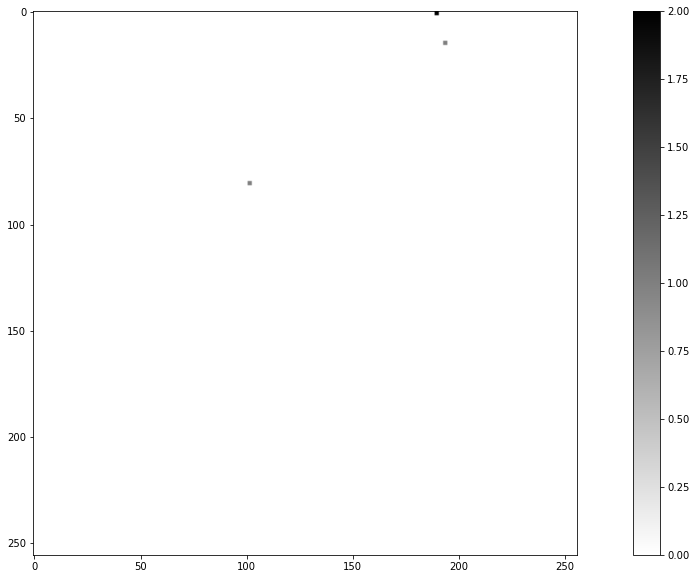

In [111]:
fig, ax = plt.subplots()
img = ax.imshow(ex_cloud_mask.read(1), cmap=plt.get_cmap("gist_yarg"))
fig.colorbar(img, ax=ax)